In [31]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,sz_o,opts = args['h0'],args['h'],args['times'], args['sz_o'], args['opts']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_o],args = params)
    return out.expect, beta, Jvalue

print("Function definition complete!!")

Function definition complete!!


In [52]:
%%time
from qutip import sigmax, sigmay, sigmaz
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (6,3),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})
freezing_pts = jn_zeros(0, 5)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0,10,400)
ea, eb = 0.03, 0.9
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]     
betas = [0.0, 1.5, 2.5, float('inf')]

hpt = jn_zeros(0,3)[0]
lamb = 0.0
lambd_x = lamb
lambd_y = lamb

nprocs = 2
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4)

sx,sy,sz = sigmax(), sigmay(), sigmaz()   
h = hpt * w/4
datap = np.zeros((N, len(times)))
            
# Define the hamiltonian at the position i,j = 0, 7
pos1, pos2 = 0, 7
i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor_0_7 = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

# Define a single spin Hamiltonian
pos_0 = 0
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_0 = Qobj(tensor(id,tensor(sz,id1)).full())


pos_0 = 7
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_7 = Qobj(tensor(id,tensor(sz,id1)).full())

params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
            'opts':opts,'sz_o':sz_cor_0_7, 'lambd_x':lambd_x,\
            'lambd_y':lambd_y, 'Jvalue':Jvalues[0],'beta':beta,\
            'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
            'opts':opts,'sz_o':sz_cor_0_7, 'lambd_x':lambd_x,\
            'lambd_y':lambd_y, 'Jvalue':Jvalues[1],'beta':beta,\
            'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

params = params1 + params2
data = p.map(run_dynm,params)




/home/mahi/anaconda3/envs/work3p8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/home/mahi/anaconda3/envs/work3p8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

ValueError: x and y must have same first dimension, but have shapes (6,) and (3,)

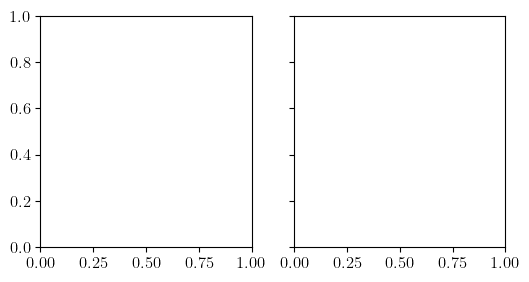

In [53]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

for i in range(8):
    sz = data[i][0][0]
    beta = data[i][1] 
    Jvalue = data[i][2]

    if Jvalue == 0.072/T:
        jj = 0
    if Jvalue == 0.2/T:
        jj = 1

    # Filter out even time periods and corresponding 's' data
    even_indices = np.arange(len(times))[::2]
    even_times = times[even_indices]
    even_sz = sz[even_indices]

    axs[jj].plot(times, even_sz, label = fr"$\beta-{beta}$")

plt.legend(frameon = False, fontsize = 9)
plt.plot()

In [57]:
import numpy as np

# Given parameters
w = 20
T = 2 * np.pi / w
times = np.linspace(0, 10 * T, 400)

# Generate some example 's' data (replace this with your actual data)
s_data = np.random.rand(400)

np.where(x==value)

# Print even time periods and corresponding 's' data
print("Even time periods:")
print(even_times)
print("\nCorresponding 's' data:")
print(even_s_data)


ZeroDivisionError: division by zero